In [4]:
%matplotlib inline
# import some dependencies
import numpy as np
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set()
except ImportError:
    pass

import torch
from torch.autograd import Variable

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

torch.manual_seed(101)

In [6]:
def scale(guess):
    # The prior over weight encodes our uncertainty about our guess
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # This encodes our belief about the noisiness of the scale:
    # the measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

conditioned_scale = pyro.condition(
    scale, data={"measurement": Variable(torch.Tensor([8.5]))})

def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)


In [8]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", Variable(torch.randn(1) + guess.data.clone(), requires_grad=True))
    b = pyro.param("b", Variable(torch.randn(1), requires_grad=True))
    return pyro.sample("weight", dist.normal, a, torch.abs(b))
# IMPORTANT: The parameters are the ones that will get updated by optimization
# (eg: by SGD). When setting requires_grad = True, it signals that (unsure?)

In [10]:

guess = Variable(torch.Tensor([8.5]))
measurement = Variable(torch.Tensor([9.5]))

conditioned_scale = pyro.condition(scale, data={"measurement": measurement})

marginal = pyro.infer.Marginal(
    pyro.infer.Importance(conditioned_scale, num_samples=100), sites=["weight"])

Text(0,0.5,u'loss')

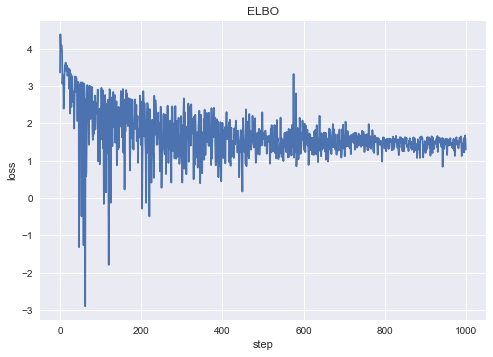

In [12]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model = conditioned_scale,
                    guide=scale_parametrized_guide,
                    optim = pyro.optim.SGD({"lr":0.001}),
                     loss = "ELBO")
losses = []
for t in range(1000):
    losses.append(svi.step(guess))
#note that the guess is piped to both the model and the guide

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

#### User can also define loss functions
For the case where the loss is the ELBO, both methods also accept an optional argument num_particles, which denotes the number of samples used to compute the loss (in the case of evaluate_loss) and the loss and gradient (in the case of step). Note that SVI also provides support for user-defined losses; see the documentation for details.

# Optimizers

In Pyro, the model and guide are allowed to be arbitrary stochastic functions provided that

1) guide doesn’t contain any pyro.observe statements

2) model and guide have the same call signature

This presents some challenges because it means that different executions of model() and guide() may have quite different behavior, with e.g. certain latent random variables and parameters only appearing some of the time. Indeed parameters may be created dynamically during the course of inference. In other words the space we’re doing optimization over, which is parameterized by θ and ϕ, can grow dynamically.

In order to support this behavior, Pyro needs to dynamically generate an optimizer for each parameter the first time it appears during learning. Luckily, PyTorch has a lightweight optimization library (see torch.optim) that can easily be repurposed for the dynamic case.

### There are two ways to specify how a new parameter would be optimized.

The simplest and oft used is aliases defined in optim/__init__.py
In simpler case optim_args is a fixed dictionary that specifies the arguments used to instantiate PyTorch optimizers for all the parameters

In [15]:
from pyro.optim import Adam
#SEE http://ruder.io/optimizing-gradient-descent/index.html#rmsprop

# Adam = Adaptive Moment Estimation is an update to the RMSProp 
# optimizer. In this optimization algorithm, running averages of 
# both the gradients (first moment/average) and the 
# second moments (variance) of the gradients are used

adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
optimizer = Adam(adam_params)


In [16]:
from pyro.optim import Adam

def per_param_callable(module_name, param_name, tags):
    #"tags = a (possibly empty) iterable of parameter tags" ?
    if 'param_name' == 'my_special_parameter':
        return {"lr": 0.010}
    else:
        return {"lr": 0.001}

optimizer = Adam(per_param_callable)

In [17]:
import pyro.distributions as dist

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = Variable(torch.Tensor([10.0]))
    beta0 = Variable(torch.Tensor([10.0]))
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.beta, alpha0, beta0)
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli
        # likelihood Bernoulli(f)
        pyro.observe("obs_{}".format(i), dist.bernoulli,
                     data[i], f)

In [19]:
def guide(data): #the guide has the same signature as the model
    #'q' refers to the guide
    #initialize the parameters of the variational inference guide
    log_alpha_q_0 = Variable(torch.Tensor([np.log(15.0)]),
                        requires_grad = True)
    log_beta_q_0 = Variable(torch.Tensor([np.log(15.0)]),
                           requires_grad = True)
    #register the parameters with pyro, and make it a pyro param.
    log_alpha_q = pyro.param("log_alpha_q",log_alpha_q_0)
    log_beta_q = pyro.param("log_beta_q",log_beta_q_0)
    alpha_q, beta_q = torch.exp(log_alpha_q), torch.exp(log_beta_q)
    #now sample/output the latent_fairness from the distribution
    #we are using a beta distribution here for the guide as well
    #NOTE how the guide and model sample names MATCH UP
    pyro.sample("latent_fairness", dist.beta, alpha_q, beta_q)
#---end function for guide


    

### the variational parameters are actually defined in log space. this is because we need alpha_q and beta_q to be non-negative in order to define a valid beta distribution. THATS why we define them in log space, and then take the EXP to make it positive numbers for the beta distr.

In [21]:
#made up data
data = Variable(torch.Tensor([1,1,1,1,0,0,0,1,1,1]))

adam_params = {"lr":0.0005, "betas" : (0.90,0.999)}
optimizer = Adam(adam_params)
#onto inference with SVI
svi = SVI(model,guide, optimizer, loss = "ELBO")
#IMPORTANT, You can also add a number of particles as in the full script 
# further below in this notebook


n_steps = 5000
#update with the gradient 
for step in range(n_steps):
    svi.step(data)

### FULL script from the tutorial in one shot

In [22]:
from __future__ import print_function
import numpy as np
import torch
from torch.autograd import Variable
import pyro
from pyro.optim import Adam
from pyro.infer import SVI
import pyro.distributions as dist

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# create some data with 6 observed heads and 4 observed tails
data = []
for _ in range(6):
    data.append(Variable(torch.ones(1)))
for _ in range(4):
    data.append(Variable(torch.zeros(1)))

def model(data):
    # define the hyperparameters that control the beta prior
    alpha0 = Variable(torch.Tensor([10.0]))
    beta0 = Variable(torch.Tensor([10.0]))
    # sample f from the beta prior
    f = pyro.sample("latent_fairness", dist.beta, alpha0, beta0)
    # loop over the observed data
    for i in range(len(data)):
        # observe datapoint i using the bernoulli likelihood
        pyro.observe("obs_{}".format(i), dist.bernoulli, data[i], f)

def guide(data):
    # define the initial values of the two variational parameters
    # we initialize the guide near the model prior (except a bit sharper)
    log_alpha_q_0 = Variable(torch.Tensor([np.log(15.0)]), requires_grad=True)
    log_beta_q_0 = Variable(torch.Tensor([np.log(15.0)]), requires_grad=True)
    # register the two variational parameters with Pyro
    log_alpha_q = pyro.param("log_alpha_q", log_alpha_q_0)
    log_beta_q = pyro.param("log_beta_q", log_beta_q_0)
    alpha_q, beta_q = torch.exp(log_alpha_q), torch.exp(log_beta_q)
    # sample latent_fairness from Beta(alpha_q, beta_q)
    pyro.sample("latent_fairness", dist.beta, alpha_q, beta_q)

# setup the optimizer
adam_params = {"lr": 0.0005, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss="ELBO", num_particles=7)

n_steps = 4000
# do gradient steps
for step in range(n_steps):
    svi.step(data)
    if step % 100 == 0:
        print('.', end='')

# grab the learned variational parameters
alpha_q = torch.exp(pyro.param("log_alpha_q")).data.numpy()[0]
beta_q = torch.exp(pyro.param("log_beta_q")).data.numpy()[0]

# here we use some facts about the beta distribution
# compute the inferred mean of the coin's fairness
inferred_mean = alpha_q / (alpha_q + beta_q)
# compute inferred standard deviation
factor = beta_q / (alpha_q * (1.0 + alpha_q + beta_q))
inferred_std = inferred_mean * np.sqrt(factor)

print("\nbased on the data and our prior belief, the fairness " +
      "of the coin is %.3f +- %.3f" % (inferred_mean, inferred_std))

........................................
based on the data and our prior belief, the fairness of the coin is 0.533 +- 0.090


### Note that we pass the argument num_particles=7 to SVI so that the ELBO gradient estimator uses seven samples to compute each estimate. We’ll describe another approach for dealing with noisy gradient estimates in 

### This estimate is to be compared to the exact posterior mean, which in this case is given by 16/30=0.53¯. we had alpha and beta as 10 before which is 20 virtual samples, and 10 data points, so totally 30 samples. 16 heads (10 virtual, 6 empirical) and hence the result. This ratio update is actually supported by the derivative approach with the beta distribution, and not just a handwaving intuition. 
Note that the final estimate of the fairness of the coin is in between the the fairness preferred by the prior (namely 0.500.50) and the fairness suggested by the raw empirical frequencies (6/10=0.606/10=0.60).

# review the update of dirichlet distr hyperparams in PGM based on likelihood. Learning of parameters
# after svi part 1, FINISH THE PAPER